In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

SEED = 42


In [2]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print(df_train.columns)
print(df_test.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#Testing

In [ ]:
df_train.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)
df_train.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)
df_train.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)
df_train.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df_train.drop('PassengerId', axis=1, inplace=True)
df_test.drop('PassengerId', axis=1, inplace=True)
df_train.drop('SibSp', axis=1, inplace=True)
df_test.drop('SibSp', axis=1, inplace=True)
df_train.drop('Parch', axis=1, inplace=True)
df_test.drop('Parch', axis=1, inplace=True)
df_train.drop('Fare', axis=1, inplace=True)
df_test.drop('Fare', axis=1, inplace=True)

In [ ]:
df_train.head()

,Survived,Pclass,Sex,Age
0,0,3,male,22.0
1,1,1,female,38.0
2,1,3,female,26.0
3,1,1,female,35.0
4,0,3,male,35.0


In [ ]:
y = df_train['Survived']
df_train.drop('Survived', axis=1, inplace=True)

In [ ]:
X_train = df_train
X_test = df_test
y_train = y

In [ ]:

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

In [ ]:
X_train['Sex']= X_train['Sex'].replace({'male': 0, 'female': 1})
X_test['Sex']= X_test['Sex'].replace({'male': 0, 'female': 1})

In [ ]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, ParameterSampler, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import time
from sklearn.metrics import f1_score
# Делим на train и holdout
X_tr, X_hold, y_tr, y_hold = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
param_dist = {
    'n_estimators': np.arange(50, 301, 25),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'max_depth': np.arange(2, 7),
    'subsample': np.linspace(0.6, 1.0, 5),
    'min_samples_leaf': np.arange(1, 11),
    'min_samples_split': np.arange(2, 21),
    'max_features': ['sqrt', 'log2', None, 0.5, 0.8],
    'ccp_alpha': np.linspace(0.0, 0.01, 5)
}
N_TRIALS = 50
N_FOLDS = 5
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
sampler = list(ParameterSampler(param_dist, n_iter=N_TRIALS, random_state=42))

best_score = 0
best_params = None

print("🔍 Начинаем ручной подбор параметров...\n")
for i, params in enumerate(sampler, 1):
    print(f"🔁 [{i}/{N_TRIALS}] Параметры: {params}")
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_tr, y_tr), 1):
        X_fold_train, X_fold_val = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
        y_fold_train, y_fold_val = y_tr.iloc[train_idx], y_tr.iloc[val_idx]

        model = GradientBoostingClassifier(random_state=42, **params)
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        f1 = f1_score(y_fold_val, y_pred)
        fold_scores.append(f1)

        print(f"   📎 Fold {fold}: f1 = {f1:.4f}")

    mean_f1 = np.mean(fold_scores)
    print(f"📊 Средняя f1: {mean_f1:.4f}\n")

    if mean_f1 > best_score:
        best_score = mean_f1
        best_params = params

# Финальный результат
print("🏁 Подбор завершён!")
print(f"✅ Лучшая средняя accuracy: {best_score:.4f}")
print("🎯 Лучшие параметры:", best_params)


🔍 Начинаем ручной подбор параметров...

🔁 [1/50] Параметры: {'subsample': np.float64(0.9), 'n_estimators': np.int64(100), 'min_samples_split': np.int64(20), 'min_samples_leaf': np.int64(4), 'max_features': None, 'max_depth': np.int64(5), 'learning_rate': np.float64(0.20999999999999996), 'ccp_alpha': np.float64(0.005)}
   📎 Fold 1: f1 = 0.7478
   📎 Fold 2: f1 = 0.6923
   📎 Fold 3: f1 = 0.6897
   📎 Fold 4: f1 = 0.7238
   📎 Fold 5: f1 = 0.6190
📊 Средняя f1: 0.6945

🔁 [2/50] Параметры: {'subsample': np.float64(0.8), 'n_estimators': np.int64(200), 'min_samples_split': np.int64(15), 'min_samples_leaf': np.int64(2), 'max_features': 0.8, 'max_depth': np.int64(6), 'learning_rate': np.float64(0.20999999999999996), 'ccp_alpha': np.float64(0.0025)}
   📎 Fold 1: f1 = 0.7523
   📎 Fold 2: f1 = 0.7059
   📎 Fold 3: f1 = 0.7677
   📎 Fold 4: f1 = 0.7255
   📎 Fold 5: f1 = 0.6190
📊 Средняя f1: 0.7141

🔁 [3/50] Параметры: {'subsample': np.float64(0.7), 'n_estimators': np.int64(225), 'min_samples_split': np.

In [ ]:
final_model = GradientBoostingClassifier(random_state=42, **best_params)
final_model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=np.float64(0.005),
                           learning_rate=np.float64(0.22999999999999998),
                           max_depth=np.int64(3), min_samples_leaf=np.int64(3),
                           min_samples_split=np.int64(16),
                           n_estimators=np.int64(275), random_state=42,
                           subsample=np.float64(0.6))

In [ ]:
props = final_model.predict_proba(X_test)
probs = pd.DataFrame(props, columns=final_model.classes_)
print(probs)
probs['pred'] = 0
pos = probs[probs[1] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head()

            0         1
0    0.858848  0.141152
1    0.462948  0.537052
2    0.835769  0.164231
3    0.858848  0.141152
4    0.462948  0.537052
..        ...       ...
413  0.858848  0.141152
414  0.140640  0.859360
415  0.858848  0.141152
416  0.858848  0.141152
417  0.858848  0.141152

[418 rows x 2 columns]


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# END Testing

In [5]:
df_train.sample(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
526,527,1,2,"Ridsdale, Miss. Lucy",female,50.0,0,0,W./C. 14258,10.5000,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
391,392,1,3,"Jansson, Mr. Carl Olof",male,21.0,0,0,350034,7.7958,NaN,S


In [6]:
correlation_matrix = df_all.select_dtypes(exclude=['object', 'category']).corr().abs()

df_all_corr = (
    correlation_matrix.unstack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation Coefficient"})
    .sort_values(by="Correlation Coefficient", ascending=False, kind="quicksort")
)

df_age_corr = df_all_corr[df_all_corr['Feature 1'] == 'Age']


In [7]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass'])['Age'].median()

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))


Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [10]:
df_all['Embarked'] = df_all['Embarked'].fillna('S') #сильно

In [11]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [12]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

In [13]:
df_all

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,M
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,C
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,M
1307,25.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,M


In [14]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

,count
Deck,
M,1014
ABC,182
DE,87
FG,26


In [15]:
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]


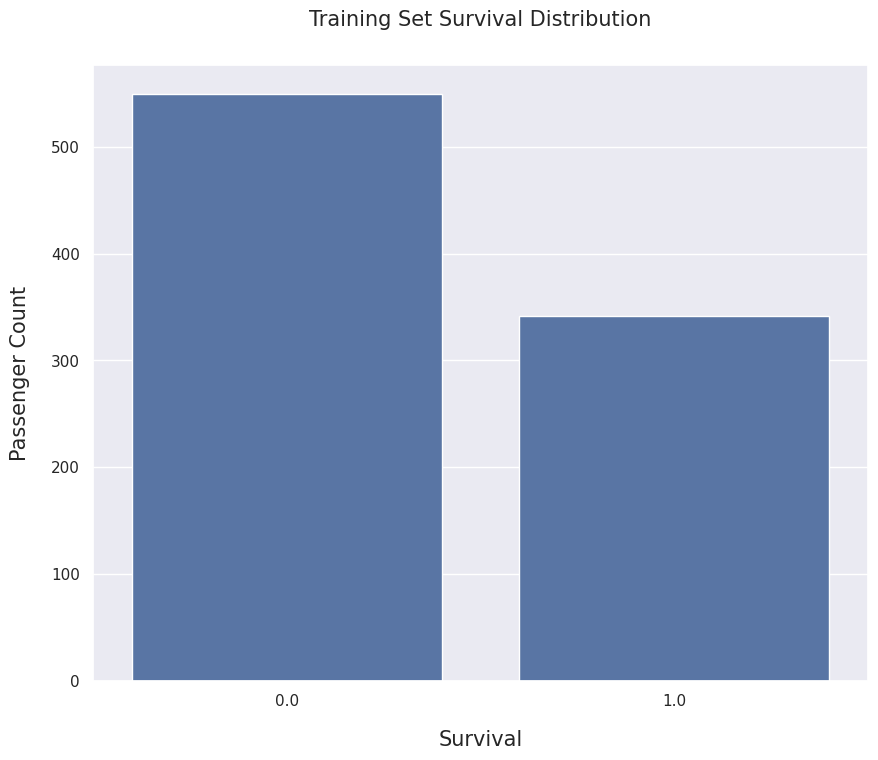

In [16]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Survived', data=df_train)

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()


In [17]:
def get_filtered_correlations(df, drop_cols=None, threshold=0.1):
    df_numeric = df.select_dtypes(exclude=['object'])
    if drop_cols:
        df_numeric = df_numeric.drop(columns=drop_cols, errors='ignore')
    corr_matrix = df_numeric.corr().abs()
    corr_pairs = (
        corr_matrix.unstack()
        .reset_index()
        .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation Coefficient"})
        .sort_values(by="Correlation Coefficient", ascending=False, kind="quicksort")
    )
    corr_pairs = corr_pairs.iloc[::2].reset_index(drop=True)
    corr_pairs = corr_pairs[corr_pairs["Correlation Coefficient"] < 1.0]
    return corr_pairs[corr_pairs["Correlation Coefficient"] > threshold]
df_train_corr_nd = get_filtered_correlations(df_train, drop_cols=['PassengerId'], threshold=0.1)
df_test_corr_nd = get_filtered_correlations(df_test, threshold=0.1)


In [18]:
df_test_corr_nd

,Feature 1,Feature 2,Correlation Coefficient
3,Fare,Pclass,0.577489
4,Pclass,Age,0.526789
5,Age,Fare,0.345347
6,SibSp,Parch,0.306895
7,Fare,Parch,0.230410
8,Fare,SibSp,0.172032


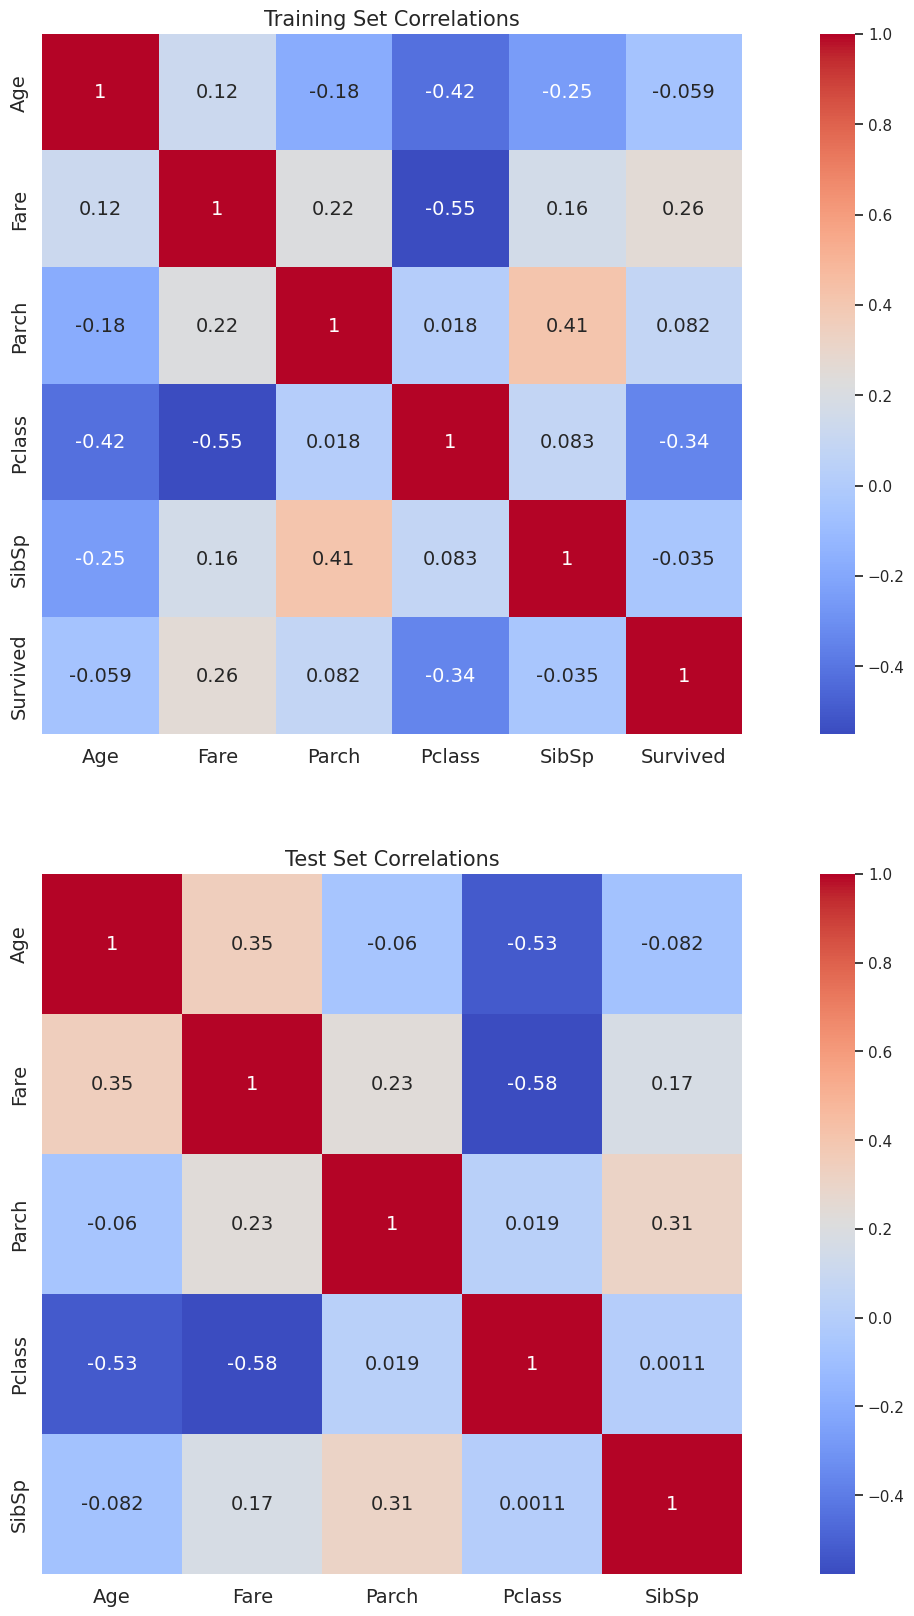

In [20]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.select_dtypes(exclude=['object']).drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.select_dtypes(exclude=['object']).drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)

axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

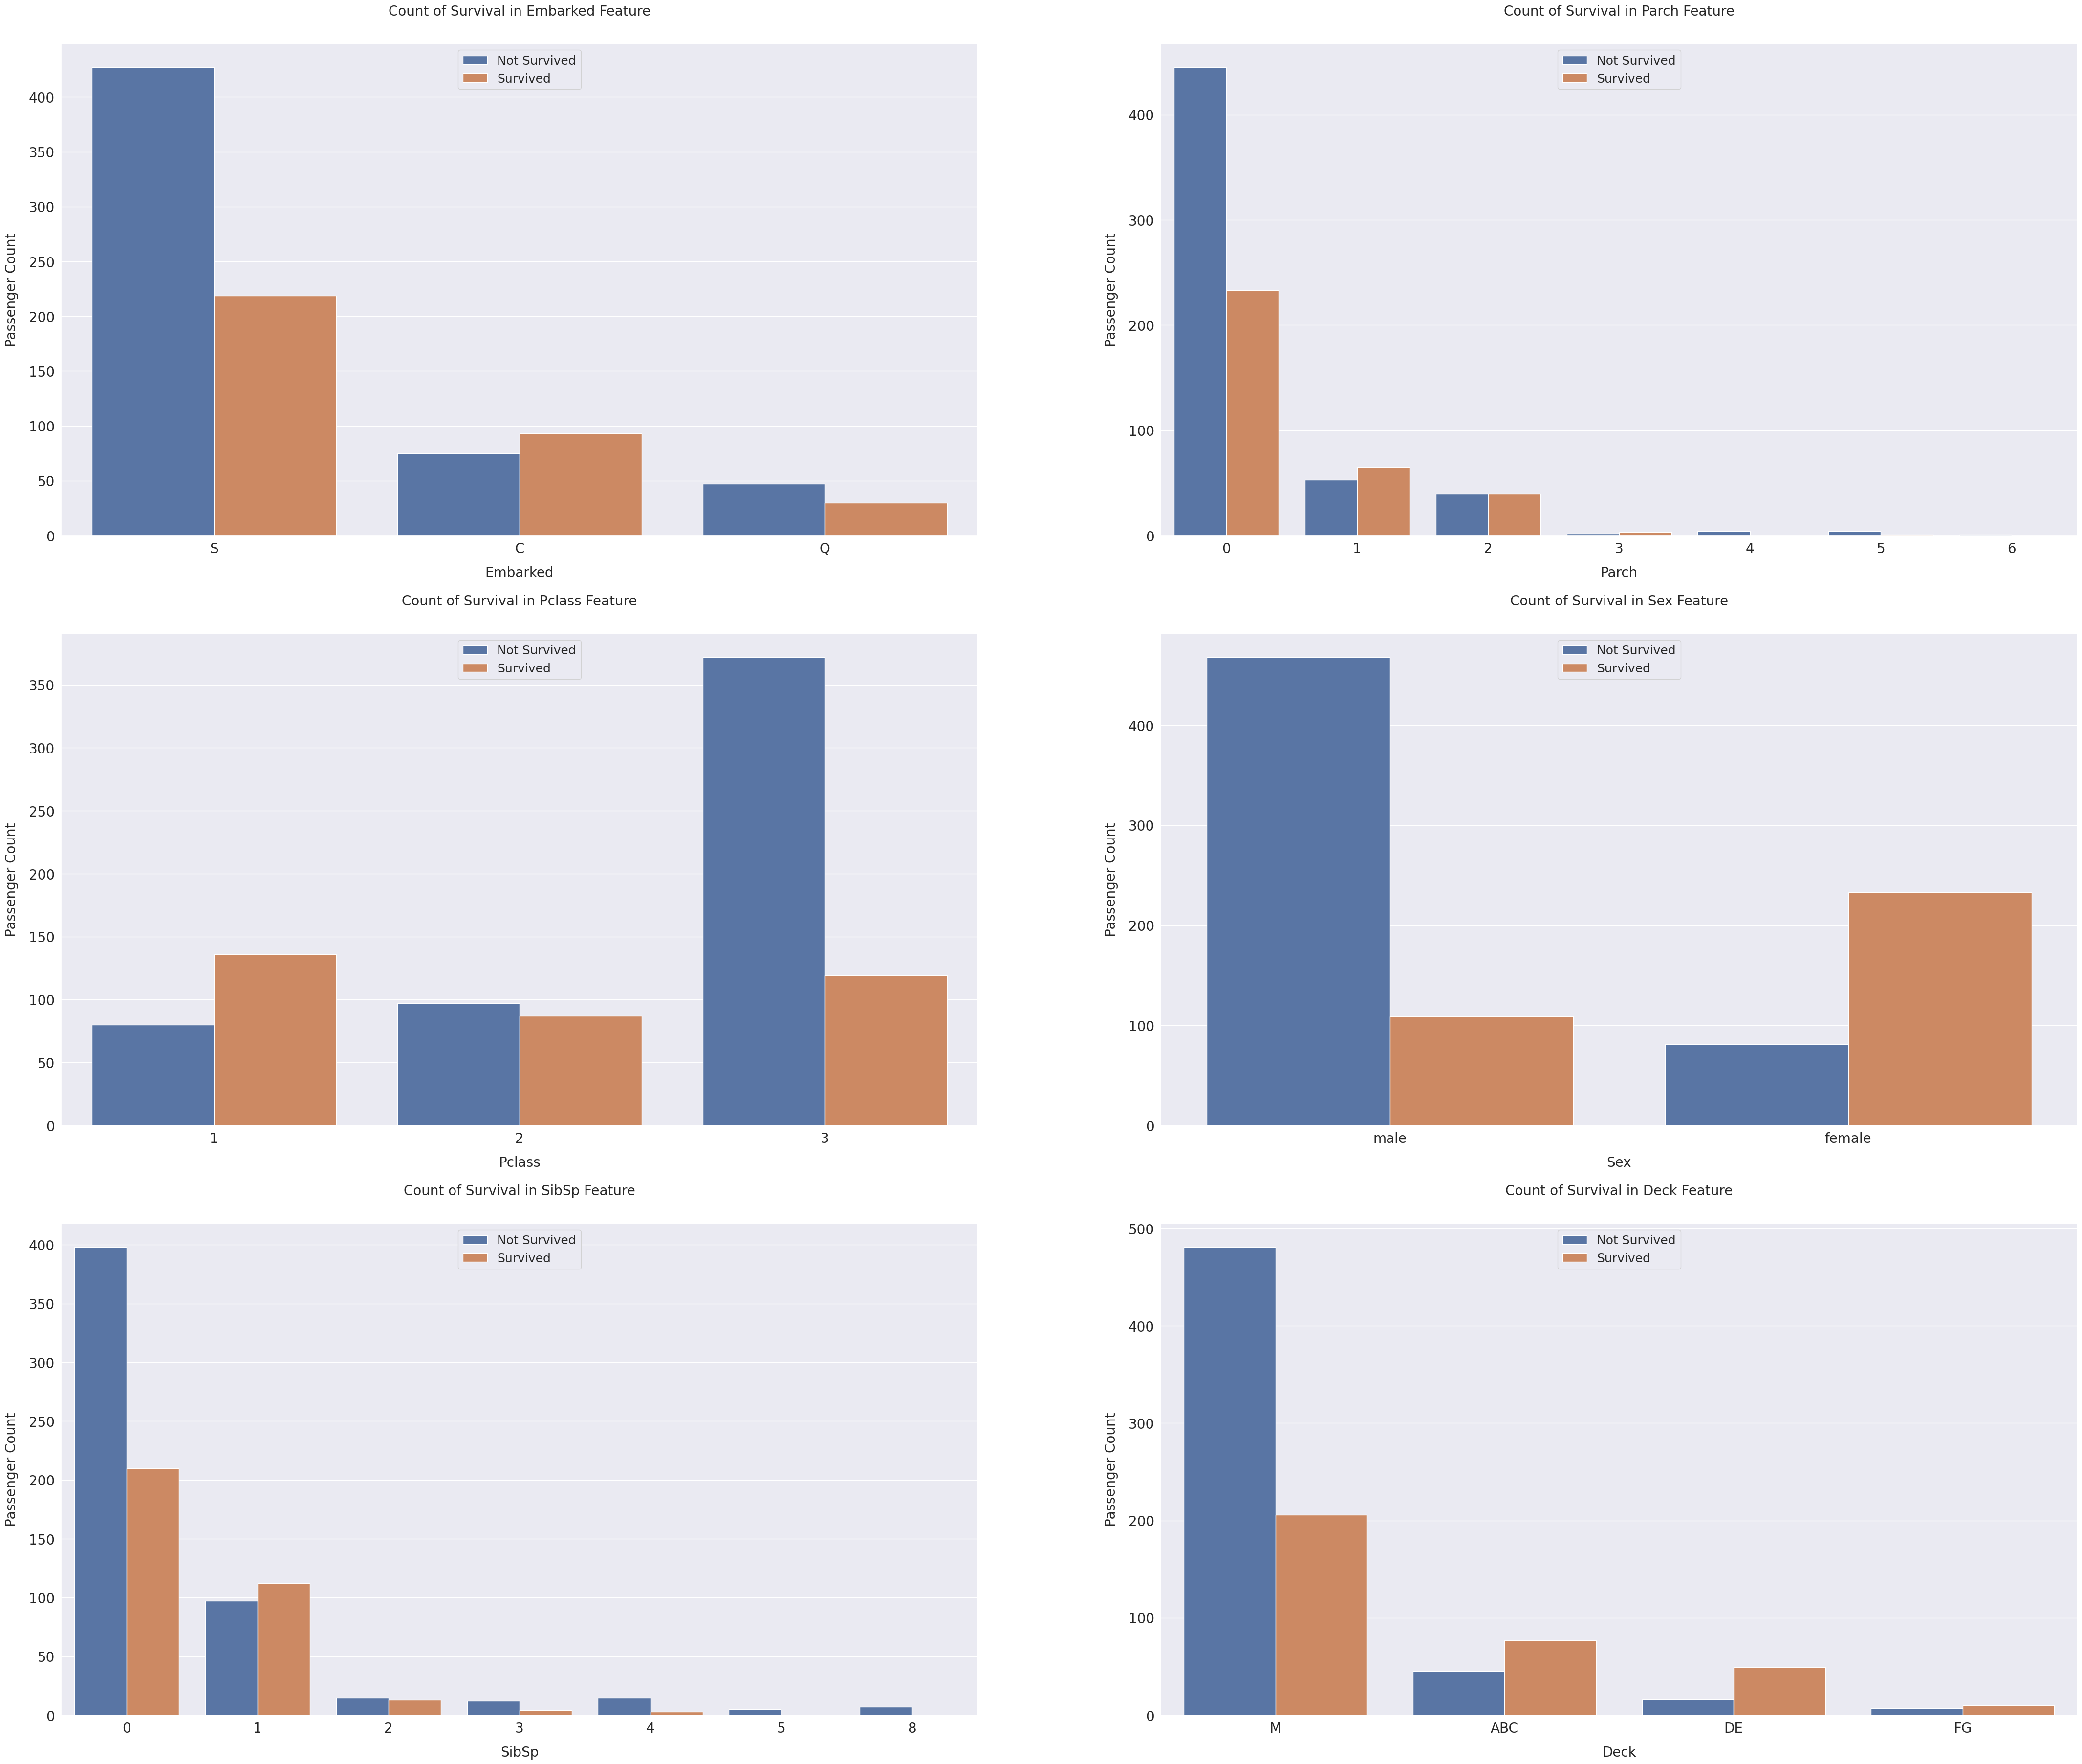

In [21]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(30, 30))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features):
    row, col = divmod(i, 2)
    ax = axs[row, col]

    sns.countplot(x=feature, hue='Survived', data=df_train, ax=ax)
    ax.set_xlabel(feature, size=20, labelpad=15)
    ax.set_ylabel('Passenger Count', size=20, labelpad=15)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    ax.set_title(f'Count of Survival in {feature} Feature', size=20, y=1.05)


In [22]:
df_all = concat_df(df_train, df_test)
df_all.head()


,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [23]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)


<Axes: xlabel='Fare', ylabel='count'>

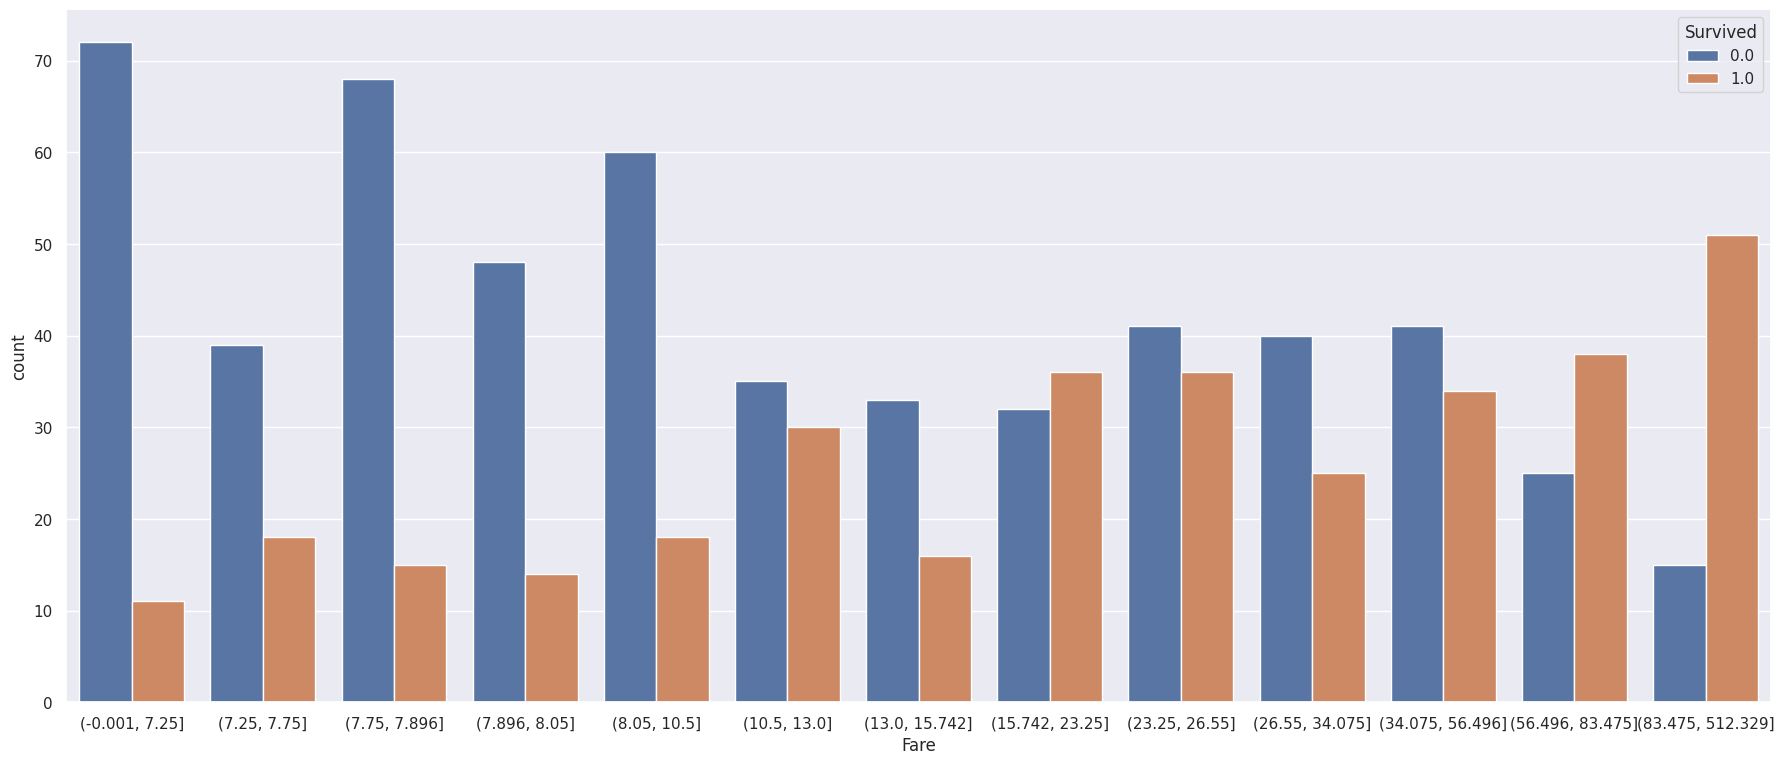

In [24]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)


#Family Size

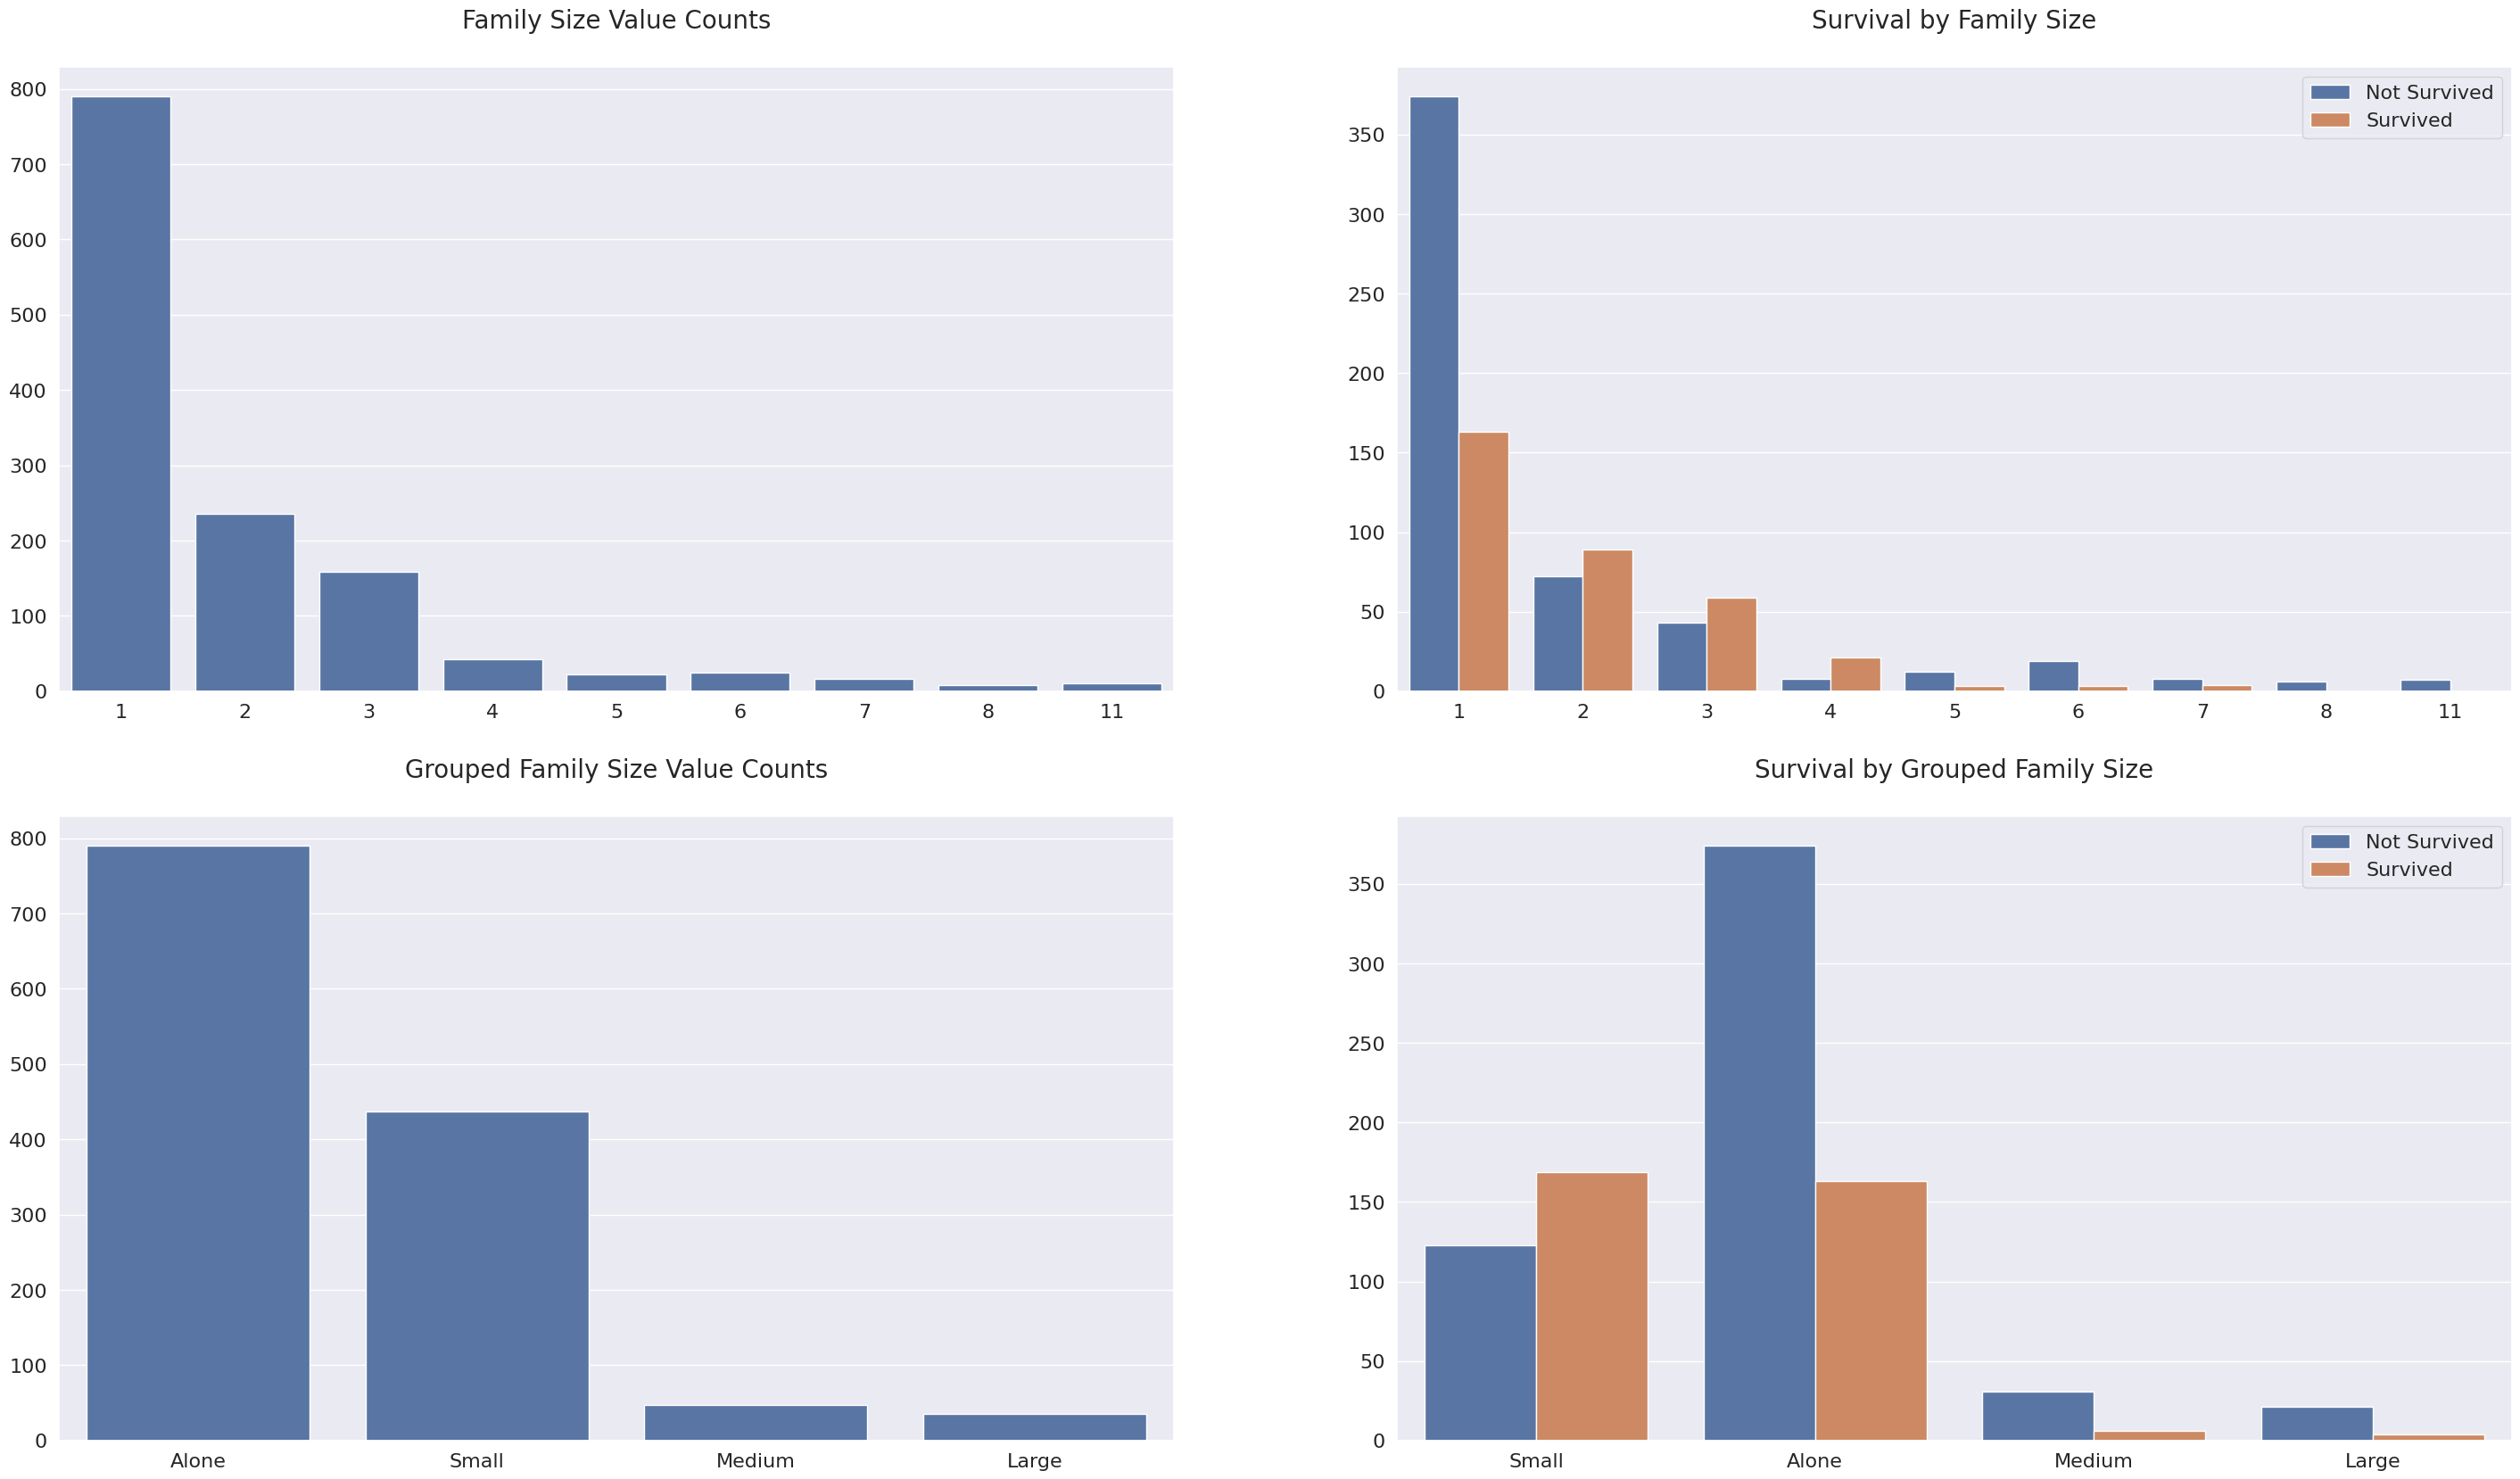

In [25]:

df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

family_map = {
    1: 'Alone',
    2: 'Small', 3: 'Small', 4: 'Small',
    5: 'Medium', 6: 'Medium',
    7: 'Large', 8: 'Large', 11: 'Large'
}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

sns.barplot(
    x=df_all['Family_Size'].value_counts().sort_index().index,
    y=df_all['Family_Size'].value_counts().sort_index().values,
    ax=axs[0][0]
)
axs[0][0].set_title('Family Size Value Counts', fontsize=20, y=1.05)

sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])
axs[0][1].set_title('Survival by Family Size', fontsize=20, y=1.05)

sns.barplot(
    x=df_all['Family_Size_Grouped'].value_counts().index,
    y=df_all['Family_Size_Grouped'].value_counts().values,
    ax=axs[1][0]
)
axs[1][0].set_title('Grouped Family Size Value Counts', fontsize=20, y=1.05)

sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])
axs[1][1].set_title('Survival by Grouped Family Size', fontsize=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 16})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=16)
        axs[i][j].tick_params(axis='y', labelsize=16)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()


In [27]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')


In [28]:
df_all.sample(20)

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency
989,20.0,M,S,"(7.75, 7.896]","Braf, Miss. Elin Ester Maria",0,990,3,female,0,NaN,347471,1,Alone,1
1206,17.0,M,Q,"(7.25, 7.75]","Hagardon, Miss. Kate",0,1207,3,female,0,NaN,AQ/3. 30631,1,Alone,1
509,26.0,M,S,"(34.075, 56.496]","Lang, Mr. Fang",0,510,3,male,0,1.0,1601,1,Alone,8
75,25.0,FG,S,"(7.25, 7.75]","Moen, Mr. Sigurd Hansen",0,76,3,male,0,0.0,348123,1,Alone,1
135,23.0,M,C,"(13.0, 15.742]","Richard, Mr. Emile",0,136,2,male,0,0.0,SC/PARIS 2133,1,Alone,1
312,26.0,M,S,"(23.25, 26.55]","Lahtinen, Mrs. William (Anna Sylfven)",1,313,2,female,1,0.0,250651,3,Small,2
182,9.0,M,S,"(26.55, 34.075]","Asplund, Master. Clarence Gustaf Hugo",2,183,3,male,4,0.0,347077,7,Large,7
220,16.0,M,S,"(7.896, 8.05]","Sunderland, Mr. Victor Francis",0,221,3,male,0,1.0,SOTON/OQ 392089,1,Alone,1
1272,26.0,M,Q,"(7.75, 7.896]","Foley, Mr. Joseph",0,1273,3,male,0,NaN,330910,1,Alone,1
1270,5.0,M,S,"(26.55, 34.075]","Asplund, Master. Carl Edgar",2,1271,3,male,4,NaN,347077,7,Large,7


In [29]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

In [30]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')


In [31]:
df_all

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,22.0,M,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1,Mr,0
1,38.0,ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2,Miss/Mrs/Ms,1
2,26.0,M,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1,Miss/Mrs/Ms,0
3,35.0,ABC,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2,Miss/Mrs/Ms,1
4,35.0,M,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.0,M,S,"(7.896, 8.05]","Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,1,Alone,1,Mr,0
1305,39.0,ABC,C,"(83.475, 512.329]","Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,1,Alone,3,Miss/Mrs/Ms,0
1306,38.5,M,S,"(-0.001, 7.25]","Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,1,Alone,1,Mr,0
1307,25.0,M,S,"(7.896, 8.05]","Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,1,Alone,1,Mr,0


In [32]:
def extract_surname(data):

    families = []

    for i in range(len(data)):
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name

        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]

        for c in string.punctuation:
            family = family.replace(c, '').strip()

        families.append(family)

    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]


In [33]:
non_unique_families = set(df_train['Family']).intersection(df_test['Family'])
non_unique_tickets = set(df_train['Ticket']).intersection(df_test['Ticket'])

df_family_survival_rate = df_train.groupby('Family')[['Survived', 'Family_Size']].median()
df_ticket_survival_rate = df_train.groupby('Ticket')[['Survived', 'Ticket_Frequency']].median()

family_rates = df_family_survival_rate[
    (df_family_survival_rate.index.isin(non_unique_families)) &
    (df_family_survival_rate['Family_Size'] > 1)
]['Survived'].to_dict()

ticket_rates = df_ticket_survival_rate[
    (df_ticket_survival_rate.index.isin(non_unique_tickets)) &
    (df_ticket_survival_rate['Ticket_Frequency'] > 1)
]['Survived'].to_dict()


In [34]:
mean_survival_rate = df_train['Survived'].mean()

def get_rate(mapping, key, default):
    return mapping.get(key, default)

def has_value(mapping, key):
    return int(key in mapping)

df_train['Family_Survival_Rate'] = df_train['Family'].map(lambda x: get_rate(family_rates, x, mean_survival_rate))
df_train['Family_Survival_Rate_NA'] = df_train['Family'].map(lambda x: has_value(family_rates, x))

df_test['Family_Survival_Rate'] = df_test['Family'].map(lambda x: get_rate(family_rates, x, mean_survival_rate))
df_test['Family_Survival_Rate_NA'] = df_test['Family'].map(lambda x: has_value(family_rates, x))

df_train['Ticket_Survival_Rate'] = df_train['Ticket'].map(lambda x: get_rate(ticket_rates, x, mean_survival_rate))
df_train['Ticket_Survival_Rate_NA'] = df_train['Ticket'].map(lambda x: has_value(ticket_rates, x))

df_test['Ticket_Survival_Rate'] = df_test['Ticket'].map(lambda x: get_rate(ticket_rates, x, mean_survival_rate))
df_test['Ticket_Survival_Rate_NA'] = df_test['Ticket'].map(lambda x: has_value(ticket_rates, x))


In [35]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2


In [36]:
df

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Frequency,Title,Is_Married,Family,Family_Survival_Rate,Family_Survival_Rate_NA,Ticket_Survival_Rate,Ticket_Survival_Rate_NA,Survival_Rate,Survival_Rate_NA
891,34.5,M,Q,"(7.75, 7.896]","Kelly, Mr. James",0,892,3,male,0,...,1,Mr,0,Kelly,0.383838,0,0.383838,0,0.383838,0.0
892,47.0,M,S,"(-0.001, 7.25]","Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,...,1,Miss/Mrs/Ms,1,Wilkes,0.383838,0,0.383838,0,0.383838,0.0
893,62.0,M,Q,"(8.05, 10.5]","Myles, Mr. Thomas Francis",0,894,2,male,0,...,1,Mr,0,Myles,0.383838,0,0.383838,0,0.383838,0.0
894,27.0,M,S,"(8.05, 10.5]","Wirz, Mr. Albert",0,895,3,male,0,...,1,Mr,0,Wirz,0.383838,0,0.383838,0,0.383838,0.0
895,22.0,M,S,"(10.5, 13.0]","Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,...,2,Miss/Mrs/Ms,1,Hirvonen,1.000000,1,1.000000,1,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.0,M,S,"(7.896, 8.05]","Spector, Mr. Woolf",0,1305,3,male,0,...,1,Mr,0,Spector,0.383838,0,0.383838,0,0.383838,0.0
1305,39.0,ABC,C,"(83.475, 512.329]","Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,...,3,Miss/Mrs/Ms,0,Oliva y Ocana,0.383838,0,0.500000,1,0.441919,0.5
1306,38.5,M,S,"(-0.001, 7.25]","Saether, Mr. Simon Sivertsen",0,1307,3,male,0,...,1,Mr,0,Saether,0.383838,0,0.383838,0,0.383838,0.0
1307,25.0,M,S,"(7.896, 8.05]","Ware, Mr. Frederick",0,1308,3,male,0,...,1,Mr,0,Ware,0.383838,0,0.383838,0,0.383838,0.0


In [37]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])


In [38]:
df

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Frequency,Title,Is_Married,Family,Family_Survival_Rate,Family_Survival_Rate_NA,Ticket_Survival_Rate,Ticket_Survival_Rate_NA,Survival_Rate,Survival_Rate_NA
891,45,3,1,2,"Kelly, Mr. James",0,892,3,1,0,...,1,3,0,Kelly,0.383838,0,0.383838,0,0.383838,0.0
892,61,3,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,...,1,2,1,Wilkes,0.383838,0,0.383838,0,0.383838,0.0
893,75,3,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,...,1,3,0,Myles,0.383838,0,0.383838,0,0.383838,0.0
894,34,3,2,4,"Wirz, Mr. Albert",0,895,3,1,0,...,1,3,0,Wirz,0.383838,0,0.383838,0,0.383838,0.0
895,27,3,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,...,2,2,1,Hirvonen,1.000000,1,1.000000,1,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,31,3,2,3,"Spector, Mr. Woolf",0,1305,3,1,0,...,1,3,0,Spector,0.383838,0,0.383838,0,0.383838,0.0
1305,52,0,0,12,"Oliva y Ocana, Dona. Fermina",0,1306,1,0,0,...,3,2,0,Oliva y Ocana,0.383838,0,0.500000,1,0.441919,0.5
1306,51,3,2,0,"Saether, Mr. Simon Sivertsen",0,1307,3,1,0,...,1,3,0,Saether,0.383838,0,0.383838,0,0.383838,0.0
1307,31,3,2,3,"Ware, Mr. Frederick",0,1308,3,1,0,...,1,3,0,Ware,0.383838,0,0.383838,0,0.383838,0.0


In [39]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']

df_all = pd.concat([df_train, df_test], axis=0)

df_all_encoded = pd.get_dummies(df_all, columns=cat_features, drop_first=False)

df_train= df_all_encoded.loc[df_train.index].copy()
df_test = df_all_encoded.loc[df_test.index].copy()


In [40]:

df_all = concat_df(df_train, df_test)
drop_cols = ['Family', 'Family_Size', 'Survived',
             'Name', 'Parch', 'PassengerId', 'SibSp', 'Ticket',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA','Survival_Rate_NA', 'Deck_2', 'Family_Size_Grouped_1', 'Embarked_2', 'Family_Size_Grouped_2', 'Deck_0', 'Pclass_3', 'Title_1', 'Is_Married']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_3,Embarked_0,Embarked_1,Family_Size_Grouped_0,Family_Size_Grouped_3,Fare,Pclass_1,Pclass_2,Sex_0,Sex_1,Survival_Rate,Ticket_Frequency,Title_0,Title_2,Title_3
0,28,False,True,False,False,False,True,0,False,False,False,True,0.383838,1,False,False,True
1,52,False,False,True,False,False,True,11,True,False,True,False,1.000000,2,False,True,False
2,34,False,True,False,False,True,False,3,False,False,True,False,0.383838,1,False,True,False
3,48,False,False,False,False,False,True,10,True,False,True,False,0.383838,2,False,True,False
4,48,False,True,False,False,True,False,3,False,False,False,True,0.383838,1,False,False,True


In [41]:
df_all.head()

,Age,Deck_1,Deck_3,Embarked_0,Embarked_1,Family_Size_Grouped_0,Family_Size_Grouped_3,Fare,Pclass_1,Pclass_2,Sex_0,Sex_1,Survival_Rate,Ticket_Frequency,Title_0,Title_2,Title_3
0,28,False,True,False,False,False,True,0,False,False,False,True,0.383838,1,False,False,True
1,52,False,False,True,False,False,True,11,True,False,True,False,1.000000,2,False,True,False
2,34,False,True,False,False,True,False,3,False,False,True,False,0.383838,1,False,True,False
3,48,False,False,False,False,False,True,10,True,False,True,False,0.383838,2,False,True,False
4,48,False,True,False,False,True,False,3,False,False,False,True,0.383838,1,False,False,True


In [42]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))


X_train shape: (891, 17)
y_train shape: (891,)
X_test shape: (418, 17)


In [43]:

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

N = 5
skf = StratifiedKFold(n_splits=N, shuffle=True, random_state=42)

probs = pd.DataFrame(0, index=np.arange(len(X_test)), columns=[f'Fold_{i}_Prob_{j}' for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(0, index=df_all.columns.drop('Survived', errors='ignore'), columns=[f'Fold_{i}' for i in range(1, N + 1)])
fprs, tprs, scores = [], [], []

oob_scores = []
per_importance = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    print(f'Fold {fold}\n')

    model = leaderboard_model
    model.fit(X_train[train_idx], y_train[train_idx])

    y_trn_pred = model.predict_proba(X_train[train_idx])[:, 1]
    y_val_pred = model.predict_proba(X_train[val_idx])[:, 1]

    trn_auc = auc(*roc_curve(y_train[train_idx], y_trn_pred)[:2])
    val_fpr, val_tpr, _ = roc_curve(y_train[val_idx], y_val_pred)
    val_auc = auc(val_fpr, val_tpr)

    scores.append((trn_auc, val_auc))
    fprs.append(val_fpr)
    tprs.append(val_tpr)

    test_proba = model.predict_proba(X_test)
    probs[f'Fold_{fold}_Prob_0'] = test_proba[:, 0]
    probs[f'Fold_{fold}_Prob_1'] = test_proba[:, 1]

    if hasattr(model, "feature_importances_"):
        importances[f'Fold_{fold}'] = model.feature_importances_

    if hasattr(model, "oob_score_"):
        print(f'Fold {fold} OOB Score: {model.oob_score_:.4f}\n')
        oob_scores.append(model.oob_score_)

    # per_result = permutation_importance(
    #     model,
    #     X_train[val_idx],             # признаки (на валидации, не на трейне!)
    #     y_train[val_idx],             # ответы
    #     n_repeats= ,      # сколько раз перемешивать каждый признак
    #     random_state=42,
    #     scoring='roc_auc'  # любая метрика: accuracy, f1, roc_auc и т.д.
    # )
    # per_importance.append(per_result.importances_mean)

if oob_scores:
    avg_oob = sum(oob_scores) / N
    print(f'Average OOB Score: {avg_oob:.4f}')

for i, (trn, val) in enumerate(scores, 1):
    print(f"Fold {i}: Train AUC = {trn:.4f}, Validation AUC = {val:.4f}")
per_importance_df = pd.DataFrame(per_importance, columns=df_all.columns.drop('Survived', errors='ignore'))
print(per_importance_df.mean(axis=0).sort_values(ascending=False))


Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 1 OOB Score: 0.8469

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 2 OOB Score: 0.8471

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 3 OOB Score: 0.8583

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

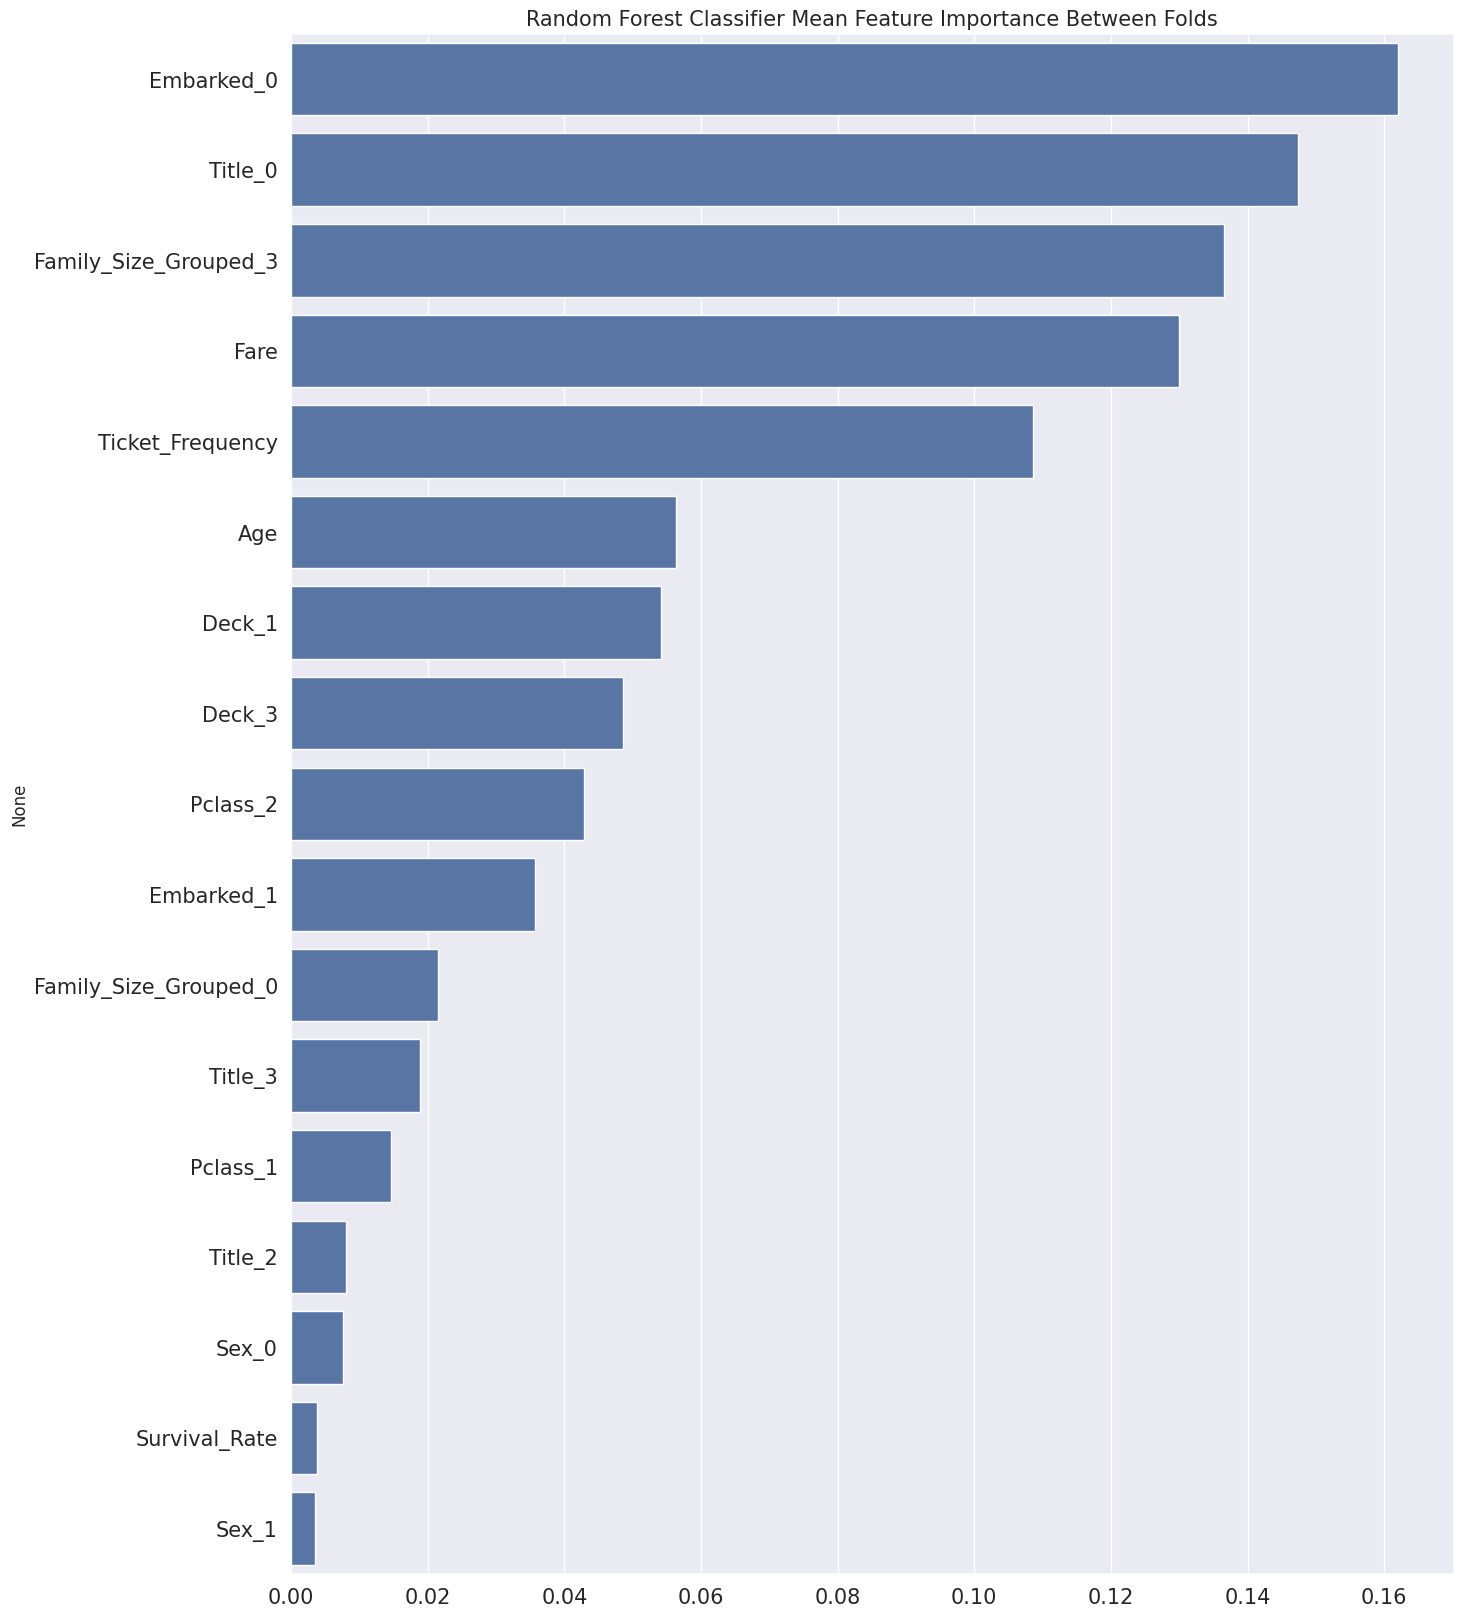

In [46]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()


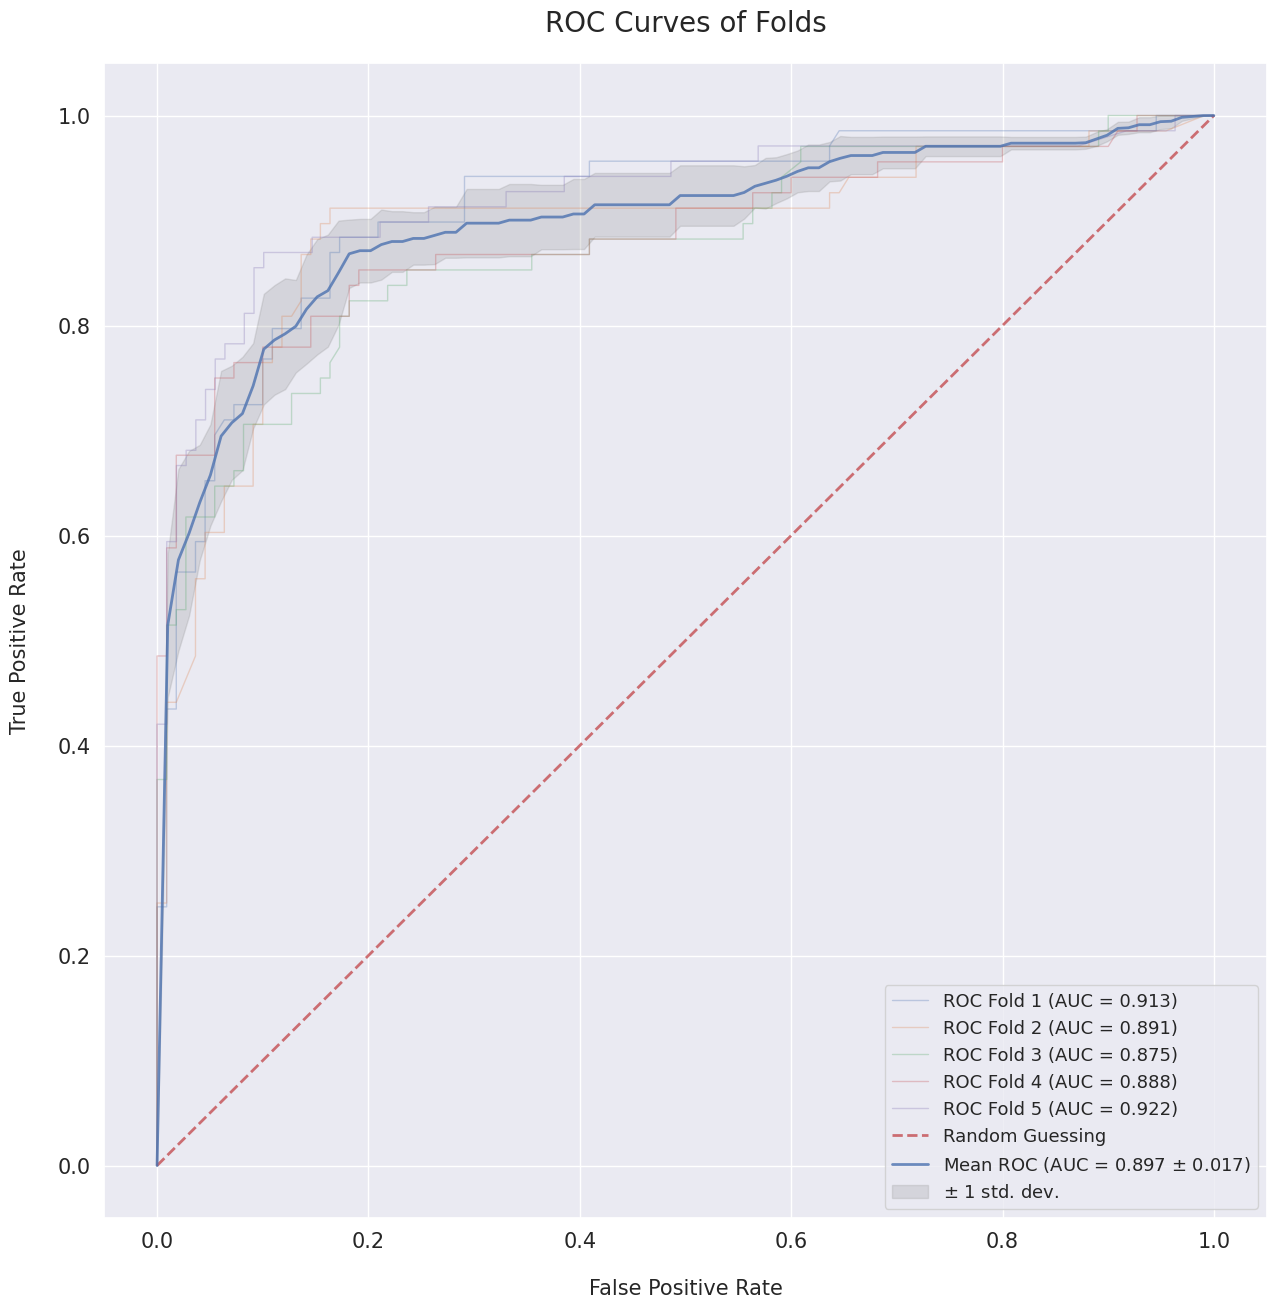

In [47]:
def plot_roc_curve(fprs, tprs):

    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))

    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))

    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)

    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')

    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})

    plt.show()

plot_roc_curve(fprs, tprs)


In [ ]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head

<bound method NDFrame.head of       PassengerId  Survived
891           892         0
892           893         1
893           894         0
894           895         0
895           896         1
...           ...       ...
1304         1305         0
1305         1306         1
1306         1307         0
1307         1308         0
1308         1309         1

[418 rows x 2 columns]>

In [ ]:
submission_df.head()

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
